In [1]:
import pydicom

# Load a DICOM image
dataset = pydicom.dcmread("/kaggle/input/siim-medical-images/dicom_dir/ID_0001_AGE_0069_CONTRAST_1_CT.dcm")

# Extract the relevant pixel value attributes
pixel_representation = dataset.PixelRepresentation
bits_allocated = dataset.BitsAllocated
bits_stored = dataset.BitsStored

# Calculate the pixel value range based on the attributes
if pixel_representation == 0:
    # Unsigned pixel representation
    data_range = 2 ** bits_stored
else:
    # Signed pixel representation
    data_range = 2 ** (bits_stored - 1)

print("Pixel Value Range:", data_range)

Pixel Value Range: 4096


In [2]:
import os
import numpy as np
import pydicom
import matplotlib.pyplot as plt
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve
from skimage.metrics import structural_similarity as ssim
from scipy.integrate import solve_ivp
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from scipy.integrate import solve_ivp
from skimage.metrics import structural_similarity as ssim
from skimage import img_as_float

In [3]:
def psnr(img1, img2, data_range=None):
    img1 = img_as_float(img1)
    img2 = img_as_float(img2)
    
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return 100
    if data_range is None:
        data_range = max(img1.max() - img1.min(), img2.max() - img2.min())
    return 20 * np.log10(data_range / np.sqrt(mse))

In [4]:
# Load the DICOM images
data_dir = '/kaggle/input/siim-medical-images/dicom_dir'
files = os.listdir(data_dir)
files.sort()
datasets = [pydicom.dcmread(os.path.join(data_dir, file)) for file in files]

In [5]:
# Extract the image data and create a 2D array
image_data = [dataset.pixel_array for dataset in datasets]
image = np.stack(image_data, axis=-1)
n, m, p = image.shape

In [6]:
# Set up the parameters for the differential equation
alpha = 0.1
d = lil_matrix((n*m, n*m))
d.setdiag(-4)
for i in range(n):
    for j in range(m):
        k = i*m + j
        if i > 0:
            d[k, (i-1)*m+j] = 1
        if i < n-1:
            d[k, (i+1)*m+j] = 1
        if j > 0:
            d[k, i*m+j-1] = 1
        if j < m-1:
            d[k, i*m+j+1] = 1
d = d / 4

In [7]:
# Define the initial condition for the differential equation
x0 = np.zeros(n*m)
for i in range(n):
    for j in range(m):
        k = i*m + j
        x0[k] = image[i, j, 0]

In [8]:
# Define the time points for the integration
t_start = 0
t_end = p-1
t = np.linspace(t_start, t_end, p)

In [9]:
# Define the differential equation for image reconstruction
def diff_eqn(t, x, A, b, alpha):
    dxdt = A.dot(x) + alpha * np.sign(x) + b
    return dxdt

In [10]:
# Define the right-hand side of the differential equation
b = np.zeros(n*m)
for i in range(n):
    for j in range(m):
        k = i*m + j
        b[k] = np.sum(image[i, j, :]) / p

In [11]:
# Solve the differential equation using solve_ivp
solution = solve_ivp(diff_eqn, [t_start, t_end], x0, t_eval=t, args=(d, b, alpha))

In [12]:
# Reshape the solution into a 3D array and plot the reconstructed image
reconstructed_image = np.reshape(solution.y, (n, m, p))

In [13]:
#Calculate PSNR, SSIM, MSE, CNR, SNR and MAPE
psnr_values = []
ssim_values = []
mse_values = []
cnr_values = []
snr_values = []
mape_values = []

#Loop through all slices and calculate the evaluation metrics
original_image = image[:, :, 0]
recon_image = reconstructed_image[:, :, 0]
  # Calculate PSNR
psnr_value = psnr(original_image, recon_image)
psnr_values.append(psnr_value)

# Calculate SSIM with specified data_range
data_range = 4096  # Assuming pixel values range from 0 to 255
ssim_value = ssim(original_image, recon_image, data_range=data_range)
ssim_values.append(ssim_value)

# Calculate MSE
mse_value = mean_squared_error(original_image, recon_image)
mse_values.append(mse_value)

# Calculate CNR
signal_mean = np.mean(original_image[original_image == 0])
roi = original_image[original_image == 0]
noise_std = np.std(roi)
cnr_value = (signal_mean - np.mean(recon_image)) / noise_std
cnr_values.append(cnr_value)

# Calculate SNR
signal_mean = np.mean(original_image)
signal_std = np.std(original_image)
snr_value = signal_mean / signal_std
snr_values.append(snr_value)

# Calculate MAPE
mape_value = mean_absolute_percentage_error(original_image, recon_image)
mape_values.append(mape_value)

print("PSNR:",psnr_value)
print('ssim:',ssim_value)
print('mse:',mse_value)
print('cnr:',cnr_value)
print('snr:',snr_value)
print('mape:',mape_value)

PSNR: 10.977627758097242
ssim: 1.0
mse: 0.0
cnr: -inf
snr: 0.781259406986513
mape: 0.0


/tmp/ipykernel_32/1099411784.py:29: RuntimeWarning: divide by zero encountered in double_scalars
  cnr_value = (signal_mean - np.mean(recon_image)) / noise_std


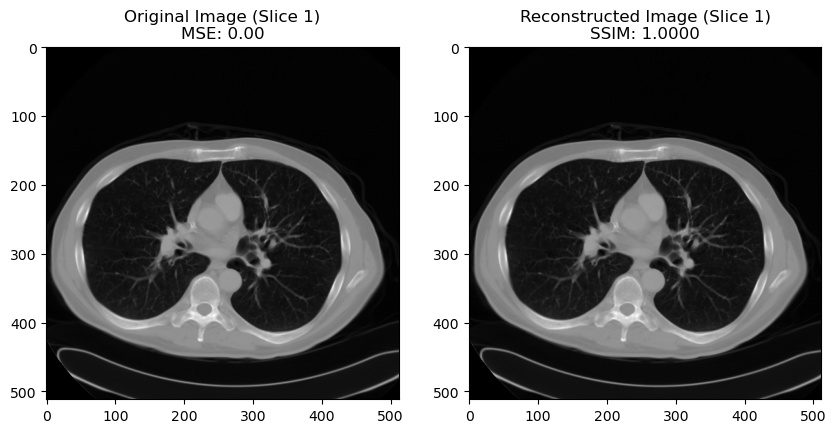

In [14]:
#Loop through all slices and plot the original and reconstructed images side by side
original_image = image[:, :, 0]
recon_image = reconstructed_image[:, :, 0]
psnr_value = psnr(original_image, recon_image)
ssim_value = ssim(original_image, recon_image, data_range=data_range)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(original_image, cmap='gray')
ax[0].set_title(f'Original Image (Slice {0+1})\nMSE: {mse_value:.2f}')
ax[1].imshow(recon_image, cmap='gray')
ax[1].set_title(f'Reconstructed Image (Slice {0+1})\nSSIM: {ssim_value:.4f}')
plt.show()